# EDA of LinkedIn profiles scraps.

## Intro

**Case:**

The dataset consists of LinkedIn profile scrapes of individuals that were part of an outreach effort. The goal of the effort is to get people to purchase a ticket to an event and ultimately join the organization as a member.

Provide an analysis that identifies what traits, characteristics, patterns, etc. can be used to indicate a higher probability of a positive/ideal outcome.

The column 'Result' has one of six outcomes for each person:
* Purchased membership: The ideal outcome, bought an event ticket and a membership
* Purchased event: A positive outcome but not ideal
* Approved: They were approved to come to an event but did not purchase
* Sent personal f/u: Conversation was started but ended
* Out of sequence: Conversation was started but ended
* 2021 Member: Someone who was a previous member of the organization.

## Data upload.

In [1]:
!pip install catboost

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re

from datetime import datetime

from sklearn.metrics import  roc_auc_score
from sklearn.model_selection import train_test_split

import catboost
from catboost import CatBoostClassifier

In [4]:
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_columns", None)

plt.rcParams['figure.figsize'] = (10, 5)

In [5]:
RANDOM_STATE = 12345

In [6]:
df = pd.read_excel('/content/drive/MyDrive/test_thumos/Linkedin Accounts That Purchased Memberships.xlsx')

In [7]:
df.head()

,linkedinProfile,Result,Other,email,description,headline,location,firstName,lastName,fullName,subscribers,userId,mutualConnectionsText,mailFromDropcontact,company,companyUrl,jobTitle,jobDescription,jobLocation,jobDateRange,company2,companyUrl2,jobTitle2,jobDescription2,jobDateRange2,school,schoolUrl,schoolDegree,schoolDegreeSpec,schoolDateRange,school2,schoolUrl2,schoolDegree2,schoolDegreeSpec2,schoolDateRange2,qualificationFromDropContact,civilityFromDropContact,phoneNumberFromDropContact,websiteFromDropContact,twitter,website,companyWebsite,allSkills,skill1,endorsement1,skill2,endorsement2,skill3,endorsement3,skill4,endorsement4,skill5,endorsement5,skill6,endorsement6,baseUrl,profileId,timestamp,jobLocation2,connectionsCount,mail,birthday,schoolDescription2,naf5CodeFromDropContact,naf5DesFromDropContact,sirenFromDropContact,siretFromDropContact,siretAddressFromDropContact,siretZipFromDropContact,vatFromDropContact,schoolDescription,nbEmployeesFromDropContact,Unnamed: 72,Unnamed: 73
0,https://www.linkedin.com/in/mark-kohoot-96a08b1,5. Purchased Membership,Hunter,mk@aeroscena.com,Mark founded Aeroscena in 2010 with the missio...,Bio-pharmaceutical / functional fragrance,"Cleveland, Ohio, United States",Mark,Kohoot,Mark Kohoot,1704.000,3172258.000,1 mutual connection: Eric Sullivan,mk@aeroscena.com,Aeroscena,https://www.linkedin.com/company/aeroscena/,CEO,Aeroscena develops and markets fragrances from...,"Cleveland/Akron, Ohio Area",Sep 2010 â€“ Present,Cleveland Clinic Wellness Institute,https://www.linkedin.com/company/cleveland-cli...,Advisor to the Chairman,Supporting the Chairman of the Wellness Instit...,2009 â€“ 2010,Audencia Nantes Ecole de Management,https://www.linkedin.com/school/19998/?legacyS...,master,marketing,1984 â€“ 1985,The Ohio State University,https://www.linkedin.com/school/19133/?legacyS...,BSBA,International Business,1979 â€“ 1983,nominative@pro,Mr,+1 800-671-1890,www.aeroscena.com,ShopAscents,stumbleupon.com/content/1LSMVB,https://aeroscena.com,"Strategic Planning, Leadership, Marketing Stra...",Strategic Planning,31,Leadership,26,Marketing Strategy,24,Strategy,21,New Business Development,18,Business Strategy,15,https://www.linkedin.com/in/mark-kohoot-96a08b1,mark-kohoot-96a08b1,2022-01-03T20:00:58.586Z,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.linkedin.com/in/jonbowerman,5. Purchased Membership,Hunter,jon@kidsdraw.org,A creative problem solver who can rapidly desi...,Co Founder and CTO - Product Development and M...,"Farmington, Michigan, United States",Jon,Bowerman,Jon Bowerman,1745.000,14910006.000,1 mutual connection: Eric Sullivan,jon@kidsdraw.org,Kids Draw Bob,https://www.linkedin.com/company/kidsdrawbob/,President and Illustrator,The energy in a room of children who've found ...,"Bloomfield Hills, MI",Jul 2019 â€“ Present,"High Level Marketing, LLC",https://www.linkedin.com/company/high-level-ma...,Co Founder and CTO - VP of Product Development,As one of the fastest growing online marketing...,Nov 2009 â€“ Present,University of Michigan,https://www.linkedin.com/school/18633/?legacyS...,Bachelor of Science (B.S.),Architecture,1999 â€“ 2004,Walled Lake Central High School,https://www.linkedin.com/school/3204390/?legac...,High School Diploma,NaN,1995 â€“ 1999,nominative@pro,Mr,NaN,www.kidsdraw.org,NaN,NaN,http://www.kidsdraw.org/donate,"Web Design, Marketing, Business Strategy, SEO,...",Web Design,99,Marketing,66,Business Strategy,11,SEO,47,Web Development,40,Online Marketing,32,https://www.linkedin.com/in/jonbowerman,jonbowerman,2022-01-03T20:01:43.218Z,"West Bloomfield, MI",NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.linkedin.com/in/parkeralynch,5. Purchased Membership,Hunter,Parker@HedgeHogHealth.com,NaN,CEO at HedgeHog Health | 2020-2021 Global Educ...,"Royal Oak, Michigan, United States",Parker,Lynch,Parker Lynch,2549.000,22364061.000,NaN,parker@hedgehoghealth.com,HedgeHog Health,https://www.linkedin.com/company/hedgehoghealth/,C

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 74 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   linkedinProfile               348 non-null    object        
 1   Result                        348 non-null    object        
 2   Other                         191 non-null    object        
 3   email                         216 non-null    object        
 4   description                   278 non-null    object        
 5   headline                      348 non-null    object        
 6   location                      348 non-null    object        
 7   firstName                     348 non-null    object        
 8   lastName                      348 non-null    object        
 9   fullName                      348 non-null    object        
 10  subscribers                   347 non-null    float64       
 11  userId                        28

Dataset contains 348 entries with 73 features each. We have multiple features containing NaN values and 2 unnamed features.

## Data processing.

First lets rename features by Python standards.

In [9]:
def to_snake_case(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [10]:
df.columns = pd.Series(df.columns).apply(to_snake_case)
df.columns

Index(['linkedin_profile', 'result', 'other', 'email', 'description',
       'headline', 'location', 'first_name', 'last_name', 'full_name',
       'subscribers', 'user_id', 'mutual_connections_text',
       'mail_from_dropcontact', 'company', 'company_url', 'job_title',
       'job_description', 'job_location', 'job_date_range', 'company2',
       'company_url2', 'job_title2', 'job_description2', 'job_date_range2',
       'school', 'school_url', 'school_degree', 'school_degree_spec',
       'school_date_range', 'school2', 'school_url2', 'school_degree2',
       'school_degree_spec2', 'school_date_range2',
       'qualification_from_drop_contact', 'civility_from_drop_contact',
       'phone_number_from_drop_contact', 'website_from_drop_contact',
       'twitter', 'website', 'company_website', 'all_skills', 'skill1',
       'endorsement1', 'skill2', 'endorsement2', 'skill3', 'endorsement3',
       'skill4', 'endorsement4', 'skill5', 'endorsement5', 'skill6',
       'endorsement6', 'base

### Column importance.

Lets mark important features for subsequent analysis.

In [11]:
df.head()

,linkedin_profile,result,other,email,description,headline,location,first_name,last_name,full_name,subscribers,user_id,mutual_connections_text,mail_from_dropcontact,company,company_url,job_title,job_description,job_location,job_date_range,company2,company_url2,job_title2,job_description2,job_date_range2,school,school_url,school_degree,school_degree_spec,school_date_range,school2,school_url2,school_degree2,school_degree_spec2,school_date_range2,qualification_from_drop_contact,civility_from_drop_contact,phone_number_from_drop_contact,website_from_drop_contact,twitter,website,company_website,all_skills,skill1,endorsement1,skill2,endorsement2,skill3,endorsement3,skill4,endorsement4,skill5,endorsement5,skill6,endorsement6,base_url,profile_id,timestamp,job_location2,connections_count,mail,birthday,school_description2,naf5_code_from_drop_contact,naf5_des_from_drop_contact,siren_from_drop_contact,siret_from_drop_contact,siret_address_from_drop_contact,siret_zip_from_drop_contact,vat_from_drop_contact,school_description,nb_employees_from_drop_contact,unnamed: 72,unnamed: 73
0,https://www.linkedin.com/in/mark-kohoot-96a08b1,5. Purchased Membership,Hunter,mk@aeroscena.com,Mark founded Aeroscena in 2010 with the missio...,Bio-pharmaceutical / functional fragrance,"Cleveland, Ohio, United States",Mark,Kohoot,Mark Kohoot,1704.000,3172258.000,1 mutual connection: Eric Sullivan,mk@aeroscena.com,Aeroscena,https://www.linkedin.com/company/aeroscena/,CEO,Aeroscena develops and markets fragrances from...,"Cleveland/Akron, Ohio Area",Sep 2010 â€“ Present,Cleveland Clinic Wellness Institute,https://www.linkedin.com/company/cleveland-cli...,Advisor to the Chairman,Supporting the Chairman of the Wellness Instit...,2009 â€“ 2010,Audencia Nantes Ecole de Management,https://www.linkedin.com/school/19998/?legacyS...,master,marketing,1984 â€“ 1985,The Ohio State University,https://www.linkedin.com/school/19133/?legacyS...,BSBA,International Business,1979 â€“ 1983,nominative@pro,Mr,+1 800-671-1890,www.aeroscena.com,ShopAscents,stumbleupon.com/content/1LSMVB,https://aeroscena.com,"Strategic Planning, Leadership, Marketing Stra...",Strategic Planning,31,Leadership,26,Marketing Strategy,24,Strategy,21,New Business Development,18,Business Strategy,15,https://www.linkedin.com/in/mark-kohoot-96a08b1,mark-kohoot-96a08b1,2022-01-03T20:00:58.586Z,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.linkedin.com/in/jonbowerman,5. Purchased Membership,Hunter,jon@kidsdraw.org,A creative problem solver who can rapidly desi...,Co Founder and CTO - Product Development and M...,"Farmington, Michigan, United States",Jon,Bowerman,Jon Bowerman,1745.000,14910006.000,1 mutual connection: Eric Sullivan,jon@kidsdraw.org,Kids Draw Bob,https://www.linkedin.com/company/kidsdrawbob/,President and Illustrator,The energy in a room of children who've found ...,"Bloomfield Hills, MI",Jul 2019 â€“ Present,"High Level Marketing, LLC",https://www.linkedin.com/company/high-level-ma...,Co Founder and CTO - VP of Product Development,As one of the fastest growing online marketing...,Nov 2009 â€“ Present,University of Michigan,https://www.linkedin.com/school/18633/?legacyS...,Bachelor of Science (B.S.),Architecture,1999 â€“ 2004,Walled Lake Central High School,https://www.linkedin.com/school/3204390/?legac...,High School Diploma,NaN,1995 â€“ 1999,nominative@pro,Mr,NaN,www.kidsdraw.org,NaN,NaN,http://www.kidsdraw.org/donate,"Web Design, Marketing, Business Strategy, SEO,...",Web Design,99,Marketing,66,Business Strategy,11,SEO,47,Web Development,40,Online Marketing,32,https://www.linkedin.com/in/jonbowerman,jonbowerman,2022-01-03T20:01:43.218Z,"West Bloomfield, MI",NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.linkedin.com/in/parkeralynch,5. Purchased Membership,Hunter,Parker@HedgeHogHealth.com,NaN,CEO at HedgeHog Health | 2020-2021 Global Educ...,"Royal Oak, Michigan, United States",Parker,Lynch,Parker Lynch,2549.000,22364061.000,NaN,parker@hed

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 74 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   linkedin_profile                 348 non-null    object        
 1   result                           348 non-null    object        
 2   other                            191 non-null    object        
 3   email                            216 non-null    object        
 4   description                      278 non-null    object        
 5   headline                         348 non-null    object        
 6   location                         348 non-null    object        
 7   first_name                       348 non-null    object        
 8   last_name                        348 non-null    object        
 9   full_name                        348 non-null    object        
 10  subscribers                      347 non-null    float64      

Since we don't have an explanation of what each feature means, lets try to understand it by analyzing values this feature can take.

**other**

In [13]:
df['other'].value_counts(dropna=False)

NaN        157
Hunter     142
Hollis      45
Lovitch      3
Janis        1
Name: other, dtype: int64

We have 4 values that look like names or surnames. It can be people who made outreach effort to a person. But that doesn't explain NaN values. In a real situation I would ask a person who was responsible for scrapes what it could mean, but fro the purposes of this test let's exclude this feature from analysis.

**qualification_from_drop_contact**

In [14]:
df['qualification_from_drop_contact'].value_counts(dropna=False)

NaN               194
nominative@pro    133
catch-all@pro      21
Name: qualification_from_drop_contact, dtype: int64

We have 3 values. Nominative means that this email is associated with a certain person, catch all means that this email can't be verified and NaN.

Since catch all and NaN basicaly have the same meaning in this scenario that e-mail was not verified we can bundle them up.

We will include this feature in analysis.

**civility_from_drop_contact**

In [15]:
df['civility_from_drop_contact'].value_counts(dropna=False)

Mr     214
NaN     71
Mrs     63
Name: civility_from_drop_contact, dtype: int64

1. linkedin_profile - nonimportant feature, it contains URL for a user profile.
2. result - our target feature.
3.

**Other drop contact features.**

In [16]:
drop_contact_f = ['naf5_code_from_drop_contact',
                  'naf5_des_from_drop_contact',
                  'siren_from_drop_contact',
                  'siret_from_drop_contact',
                  'siret_address_from_drop_contact',
                  'siret_zip_from_drop_contact',
                  'vat_from_drop_contact',
                  'nb_employees_from_drop_contact']

In [17]:
for feature in drop_contact_f:
    print(df[feature].value_counts(dropna=False))
    print('')

NaN       332
68.20B      3
70.10Z      2
86.23Z      1
71..1Z      1
81.30Z      1
56.10A      1
63.11Z      1
28..15      1
59.11A      1
62.01Z      1
43.39Z      1
55.20Z      1
82.99Z      1
Name: naf5_code_from_drop_contact, dtype: int64

NaN                                                                334
Location de terrains et d'autres biens immobiliers                   3
ActivitÃ©s des siÃ¨ges sociaux                                       2
Pratique dentaire                                                    1
Services d'amÃ©nagement paysager                                     1
Restauration traditionnelle                                          1
Traitement de donnÃ©es, hÃ©bergement et activitÃ©s connexes          1
Production de films et de programmes pour la tÃ©lÃ©vision            1
Programmation informatique                                           1
Autres travaux de finition                                           1
HÃ©bergement touristique et autre hÃ©bergemen

This features contain only handful of relevant data, most of it is NaN, let's check what percentage of relevant data exists for each feature.

In [18]:
for feature in drop_contact_f:
    frac = len(df[feature].dropna()) / len(df[feature])
    print(feature)
    print(f'Relevant data percentage: {frac:.1%}')
    print('')

naf5_code_from_drop_contact
Relevant data percentage: 4.6%

naf5_des_from_drop_contact
Relevant data percentage: 4.0%

siren_from_drop_contact
Relevant data percentage: 4.6%

siret_from_drop_contact
Relevant data percentage: 4.6%

siret_address_from_drop_contact
Relevant data percentage: 4.3%

siret_zip_from_drop_contact
Relevant data percentage: 4.3%

vat_from_drop_contact
Relevant data percentage: 4.6%

nb_employees_from_drop_contact
Relevant data percentage: 3.4%



**Unnamed features**

Since unnamed: 72 only contains NaN values let's look at unnamed: 73.

In [19]:
df['unnamed: 73'].value_counts(dropna=False)

NaN                              286
kathryn@apolloneuro.com            1
jackee@deliccorp.com               1
jacob@nopapermenu.com              1
jake@upwellness.com                1
                                ... 
ewa@tribe47.com                    1
francis.wolff@digistore24.com      1
gary@usawa.io                      1
gordy.bal@ctr.com                  1
margaret.conger@biocidin.com       1
Name: unnamed: 73, Length: 63, dtype: int64

In [20]:
df_unnamed = df[df['unnamed: 73'].notna()]
df_unnamed.head()

,linkedin_profile,result,other,email,description,headline,location,first_name,last_name,full_name,subscribers,user_id,mutual_connections_text,mail_from_dropcontact,company,company_url,job_title,job_description,job_location,job_date_range,company2,company_url2,job_title2,job_description2,job_date_range2,school,school_url,school_degree,school_degree_spec,school_date_range,school2,school_url2,school_degree2,school_degree_spec2,school_date_range2,qualification_from_drop_contact,civility_from_drop_contact,phone_number_from_drop_contact,website_from_drop_contact,twitter,website,company_website,all_skills,skill1,endorsement1,skill2,endorsement2,skill3,endorsement3,skill4,endorsement4,skill5,endorsement5,skill6,endorsement6,base_url,profile_id,timestamp,job_location2,connections_count,mail,birthday,school_description2,naf5_code_from_drop_contact,naf5_des_from_drop_contact,siren_from_drop_contact,siret_from_drop_contact,siret_address_from_drop_contact,siret_zip_from_drop_contact,vat_from_drop_contact,school_description,nb_employees_from_drop_contact,unnamed: 72,unnamed: 73
251,https://www.linkedin.com/in/adamweiler1/,2021 Member,NaN,adam@sunkenstone.com,Each day your brand doesn't have an optimized ...,"Founder, Sunken Stone â€¢ Helping Challenger ...","Seattle, Washington, United States",Adam,Weiler,Adam Weiler,2420.000,8868161.000,NaN,NaN,Sunken Stone,https://www.linkedin.com/company/sunken-stone/,Founder,"Performance based, Amazon Management. We help ...",Greater San Diego Area,Dec 2007 â€“ Present,StrongVolt,NaN,Co-Founder,StrongVolt is about creating products that â€œ...,Sep 2009 â€“ Sep 2017,San Diego State University,https://www.linkedin.com/school/17905/?legacyS...,MBA,Marketing,2008 â€“ 2010,San Diego State University-California State Un...,https://www.linkedin.com/school/17905/?legacyS...,BA,Political Science,2001 â€“ 2005,NaN,Mr,NaN,www.sunkenstone.com,NaN,sunkenstone.com,http://sunkenstone.com,"Marketing, Sales, Product Development, Marketi...",Marketing,24,Sales,20,Product Development,19,Marketing Strategy,12,Product Marketing,10,Sales Management,7,https://www.linkedin.com/in/adamweiler1,adamweiler1,2022-01-19T13:09:23.984Z,Greater San Diego Area,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adam@sunkenstone.com
255,https://www.linkedin.com/in/andyfossett/,2021 Member,NaN,af@gmb.io,"Often breaking things. Occasionally, on purpose.",Dilettante. Burger enthusiast. Nominal leader.,Greater Tokyo Area,Andy,Fossett,Andy Fossett,229.000,15384292.000,NaN,NaN,GMB Fitness,https://www.linkedin.com/company/gold-medal-bo...,CEO,NaN,NaN,Jun 2010 â€“ Present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mr,NaN,www.gmb.io,AndyFossett,gmb.io,https://gmb.io,"Karaoke, Reclining, Reading, Inappropriate Hum...",Karaoke,0,Reclining,0,Reading,0,Inappropriate Humor,0,Bourbon,0,NaN,NaN,https://www.linkedin.com/in/andyfossett,andyfossett,2022-01-19T13:12:41.596Z,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,af@gmb.io
256,https://www.linkedin.com/in/angelokeely/,2021 Member,NaN,akeely@getkion.com,Angelo is an executive leader with experience ...,Co-Founder & CEO at Kion,"Boulder, Colorado, United States",Angelo,Keely,Angelo Keely,2724.000,18569187.000,NaN,NaN,Kion,https://www.linkedin.com/company/getkion/,Co-Founder & CEO,Launched and lead health and fitness company.,NaN,Mar 2017 â€“ Present,Something Else LLC,https://www.linkedin.com/company/something-els...,Founder,Helping the world to be more creative.,Oct 2010 â€“ Present,St. Edward's University,https://www.linkedin.com/school/19483/?legacyS...,Bachelor's degree,NaN,NaN,UniversitÃ© Paris-Sorbonne,https://www.linkedin.com/school/12548/?legacyS...,NaN,French Language and Civilization,NaN,NaN,Mr,NaN,www.getkion.com,NaN,NaN,http://getkion.com,"Business Development, Team Management, Marketi...",Business Development,41,Team Management,36,Marketing,34,Strategic Planning,20,Marketing Strategy,16,Consulting,14,https://www.linkedin.com/in/angelokeely,angelokeely,2

In [21]:
df_unnamed[df['email'] != df['unnamed: 73']]

<ipython-input-21-5975b91fe4ca>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_unnamed[df['email'] != df['unnamed: 73']]


,linkedin_profile,result,other,email,description,headline,location,first_name,last_name,full_name,subscribers,user_id,mutual_connections_text,mail_from_dropcontact,company,company_url,job_title,job_description,job_location,job_date_range,company2,company_url2,job_title2,job_description2,job_date_range2,school,school_url,school_degree,school_degree_spec,school_date_range,school2,school_url2,school_degree2,school_degree_spec2,school_date_range2,qualification_from_drop_contact,civility_from_drop_contact,phone_number_from_drop_contact,website_from_drop_contact,twitter,website,company_website,all_skills,skill1,endorsement1,skill2,endorsement2,skill3,endorsement3,skill4,endorsement4,skill5,endorsement5,skill6,endorsement6,base_url,profile_id,timestamp,job_location2,connections_count,mail,birthday,school_description2,naf5_code_from_drop_contact,naf5_des_from_drop_contact,siren_from_drop_contact,siret_from_drop_contact,siret_address_from_drop_contact,siret_zip_from_drop_contact,vat_from_drop_contact,school_description,nb_employees_from_drop_contact,unnamed: 72,unnamed: 73


As we can see unnamed: 73, duplicates email. Since the particular purpose of this feature is not known let's exclude ot from analysis.

### Feature processing.

In [22]:
df.head()

,linkedin_profile,result,other,email,description,headline,location,first_name,last_name,full_name,subscribers,user_id,mutual_connections_text,mail_from_dropcontact,company,company_url,job_title,job_description,job_location,job_date_range,company2,company_url2,job_title2,job_description2,job_date_range2,school,school_url,school_degree,school_degree_spec,school_date_range,school2,school_url2,school_degree2,school_degree_spec2,school_date_range2,qualification_from_drop_contact,civility_from_drop_contact,phone_number_from_drop_contact,website_from_drop_contact,twitter,website,company_website,all_skills,skill1,endorsement1,skill2,endorsement2,skill3,endorsement3,skill4,endorsement4,skill5,endorsement5,skill6,endorsement6,base_url,profile_id,timestamp,job_location2,connections_count,mail,birthday,school_description2,naf5_code_from_drop_contact,naf5_des_from_drop_contact,siren_from_drop_contact,siret_from_drop_contact,siret_address_from_drop_contact,siret_zip_from_drop_contact,vat_from_drop_contact,school_description,nb_employees_from_drop_contact,unnamed: 72,unnamed: 73
0,https://www.linkedin.com/in/mark-kohoot-96a08b1,5. Purchased Membership,Hunter,mk@aeroscena.com,Mark founded Aeroscena in 2010 with the missio...,Bio-pharmaceutical / functional fragrance,"Cleveland, Ohio, United States",Mark,Kohoot,Mark Kohoot,1704.000,3172258.000,1 mutual connection: Eric Sullivan,mk@aeroscena.com,Aeroscena,https://www.linkedin.com/company/aeroscena/,CEO,Aeroscena develops and markets fragrances from...,"Cleveland/Akron, Ohio Area",Sep 2010 â€“ Present,Cleveland Clinic Wellness Institute,https://www.linkedin.com/company/cleveland-cli...,Advisor to the Chairman,Supporting the Chairman of the Wellness Instit...,2009 â€“ 2010,Audencia Nantes Ecole de Management,https://www.linkedin.com/school/19998/?legacyS...,master,marketing,1984 â€“ 1985,The Ohio State University,https://www.linkedin.com/school/19133/?legacyS...,BSBA,International Business,1979 â€“ 1983,nominative@pro,Mr,+1 800-671-1890,www.aeroscena.com,ShopAscents,stumbleupon.com/content/1LSMVB,https://aeroscena.com,"Strategic Planning, Leadership, Marketing Stra...",Strategic Planning,31,Leadership,26,Marketing Strategy,24,Strategy,21,New Business Development,18,Business Strategy,15,https://www.linkedin.com/in/mark-kohoot-96a08b1,mark-kohoot-96a08b1,2022-01-03T20:00:58.586Z,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.linkedin.com/in/jonbowerman,5. Purchased Membership,Hunter,jon@kidsdraw.org,A creative problem solver who can rapidly desi...,Co Founder and CTO - Product Development and M...,"Farmington, Michigan, United States",Jon,Bowerman,Jon Bowerman,1745.000,14910006.000,1 mutual connection: Eric Sullivan,jon@kidsdraw.org,Kids Draw Bob,https://www.linkedin.com/company/kidsdrawbob/,President and Illustrator,The energy in a room of children who've found ...,"Bloomfield Hills, MI",Jul 2019 â€“ Present,"High Level Marketing, LLC",https://www.linkedin.com/company/high-level-ma...,Co Founder and CTO - VP of Product Development,As one of the fastest growing online marketing...,Nov 2009 â€“ Present,University of Michigan,https://www.linkedin.com/school/18633/?legacyS...,Bachelor of Science (B.S.),Architecture,1999 â€“ 2004,Walled Lake Central High School,https://www.linkedin.com/school/3204390/?legac...,High School Diploma,NaN,1995 â€“ 1999,nominative@pro,Mr,NaN,www.kidsdraw.org,NaN,NaN,http://www.kidsdraw.org/donate,"Web Design, Marketing, Business Strategy, SEO,...",Web Design,99,Marketing,66,Business Strategy,11,SEO,47,Web Development,40,Online Marketing,32,https://www.linkedin.com/in/jonbowerman,jonbowerman,2022-01-03T20:01:43.218Z,"West Bloomfield, MI",NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.linkedin.com/in/parkeralynch,5. Purchased Membership,Hunter,Parker@HedgeHogHealth.com,NaN,CEO at HedgeHog Health | 2020-2021 Global Educ...,"Royal Oak, Michigan, United States",Parker,Lynch,Parker Lynch,2549.000,22364061.000,NaN,parker@hed

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 74 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   linkedin_profile                 348 non-null    object        
 1   result                           348 non-null    object        
 2   other                            191 non-null    object        
 3   email                            216 non-null    object        
 4   description                      278 non-null    object        
 5   headline                         348 non-null    object        
 6   location                         348 non-null    object        
 7   first_name                       348 non-null    object        
 8   last_name                        348 non-null    object        
 9   full_name                        348 non-null    object        
 10  subscribers                      347 non-null    float64      

First of all let's remove all unnecessary columns.

**Note:** we can extract more info from text features using NLP. For the purposes of this test task NLP was no used to extract more info and/or features.

In [24]:
columns_to_drop = ['other',
                   'first_name',
                   'last_name',
                   'full_name',
                   'user_id',
                   'company_url',
                   'company_url2',
                   'school_url',
                   'school_url2',
                   'base_url',
                   'profile_id',
                   'timestamp',
                   'mail',
                   'unnamed: 72',
                   'unnamed: 73']

In [25]:
columns_to_drop

['other',
 'first_name',
 'last_name',
 'full_name',
 'user_id',
 'company_url',
 'company_url2',
 'school_url',
 'school_url2',
 'base_url',
 'profile_id',
 'timestamp',
 'mail',
 'unnamed: 72',
 'unnamed: 73']

In [26]:
df_eda = df.drop(columns_to_drop, axis=1)

In [27]:
df_eda.head()

,linkedin_profile,result,email,description,headline,location,subscribers,mutual_connections_text,mail_from_dropcontact,company,job_title,job_description,job_location,job_date_range,company2,job_title2,job_description2,job_date_range2,school,school_degree,school_degree_spec,school_date_range,school2,school_degree2,school_degree_spec2,school_date_range2,qualification_from_drop_contact,civility_from_drop_contact,phone_number_from_drop_contact,website_from_drop_contact,twitter,website,company_website,all_skills,skill1,endorsement1,skill2,endorsement2,skill3,endorsement3,skill4,endorsement4,skill5,endorsement5,skill6,endorsement6,job_location2,connections_count,birthday,school_description2,naf5_code_from_drop_contact,naf5_des_from_drop_contact,siren_from_drop_contact,siret_from_drop_contact,siret_address_from_drop_contact,siret_zip_from_drop_contact,vat_from_drop_contact,school_description,nb_employees_from_drop_contact
0,https://www.linkedin.com/in/mark-kohoot-96a08b1,5. Purchased Membership,mk@aeroscena.com,Mark founded Aeroscena in 2010 with the missio...,Bio-pharmaceutical / functional fragrance,"Cleveland, Ohio, United States",1704.000,1 mutual connection: Eric Sullivan,mk@aeroscena.com,Aeroscena,CEO,Aeroscena develops and markets fragrances from...,"Cleveland/Akron, Ohio Area",Sep 2010 â€“ Present,Cleveland Clinic Wellness Institute,Advisor to the Chairman,Supporting the Chairman of the Wellness Instit...,2009 â€“ 2010,Audencia Nantes Ecole de Management,master,marketing,1984 â€“ 1985,The Ohio State University,BSBA,International Business,1979 â€“ 1983,nominative@pro,Mr,+1 800-671-1890,www.aeroscena.com,ShopAscents,stumbleupon.com/content/1LSMVB,https://aeroscena.com,"Strategic Planning, Leadership, Marketing Stra...",Strategic Planning,31,Leadership,26,Marketing Strategy,24,Strategy,21,New Business Development,18,Business Strategy,15,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.linkedin.com/in/jonbowerman,5. Purchased Membership,jon@kidsdraw.org,A creative problem solver who can rapidly desi...,Co Founder and CTO - Product Development and M...,"Farmington, Michigan, United States",1745.000,1 mutual connection: Eric Sullivan,jon@kidsdraw.org,Kids Draw Bob,President and Illustrator,The energy in a room of children who've found ...,"Bloomfield Hills, MI",Jul 2019 â€“ Present,"High Level Marketing, LLC",Co Founder and CTO - VP of Product Development,As one of the fastest growing online marketing...,Nov 2009 â€“ Present,University of Michigan,Bachelor of Science (B.S.),Architecture,1999 â€“ 2004,Walled Lake Central High School,High School Diploma,NaN,1995 â€“ 1999,nominative@pro,Mr,NaN,www.kidsdraw.org,NaN,NaN,http://www.kidsdraw.org/donate,"Web Design, Marketing, Business Strategy, SEO,...",Web Design,99,Marketing,66,Business Strategy,11,SEO,47,Web Development,40,Online Marketing,32,"West Bloomfield, MI",NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.linkedin.com/in/parkeralynch,5. Purchased Membership,Parker@HedgeHogHealth.com,NaN,CEO at HedgeHog Health | 2020-2021 Global Educ...,"Royal Oak, Michigan, United States",2549.000,NaN,parker@hedgehoghealth.com,HedgeHog Health,Chief Executive Officer,Revolutionizing education technology and welln...,NaN,Nov 2019 â€“ Present,Born and Raised Detroit Foundation,Executive Director,â€¢Organize events in cities from coast to coa...,Jan 2016 â€“ Present,New York University,Dual MA,"Childhood Education, Special Education",2011 â€“ 2013,Indiana University Bloomington,Bachelor's degree,"English Language and Literature, General",2002 â€“ 2006,nominative@pro,Mr,+248 6 577 050,www.hedgehoghealth.com,NaN,bornandraiseddetroit.org/,http://www.hedgehoghealth.com,"Editing, Blogging, Social Media, Event Plannin...",Editing,39,Blogging,31,Social Media,25,Event Planning,14,SEO,11,Curriculum Development,8,Greater Detroit Area,500.000,2023-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.linkedin.com/in/shacharschiff,5. Purchased Membership,shachar@badtesting.co

In [28]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 59 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   linkedin_profile                 348 non-null    object        
 1   result                           348 non-null    object        
 2   email                            216 non-null    object        
 3   description                      278 non-null    object        
 4   headline                         348 non-null    object        
 5   location                         348 non-null    object        
 6   subscribers                      347 non-null    float64       
 7   mutual_connections_text          4 non-null      object        
 8   mail_from_dropcontact            154 non-null    object        
 9   company                          346 non-null    object        
 10  job_title                        347 non-null    object       

Lets make some feature boolean for analysis.

Some text features don't have relevant information by themselves but may provide information for analysis if a person added them to their profile.

In [29]:
columns_to_bool = ['email',
                   'description',
                   'headline',
                   'mail_from_dropcontact',
                   'job_description',
                   'job_description2',
                   'qualification_from_drop_contact',
                   'website_from_drop_contact',
                   'twitter',
                   'website',
                   'company_website',
                   'school_description',
                   'school_description2',
                   'birthday',
                   'phone_number_from_drop_contact'] + drop_contact_f

In [30]:
columns_to_bool

['email',
 'description',
 'headline',
 'mail_from_dropcontact',
 'job_description',
 'job_description2',
 'qualification_from_drop_contact',
 'website_from_drop_contact',
 'twitter',
 'website',
 'company_website',
 'school_description',
 'school_description2',
 'birthday',
 'phone_number_from_drop_contact',
 'naf5_code_from_drop_contact',
 'naf5_des_from_drop_contact',
 'siren_from_drop_contact',
 'siret_from_drop_contact',
 'siret_address_from_drop_contact',
 'siret_zip_from_drop_contact',
 'vat_from_drop_contact',
 'nb_employees_from_drop_contact']

In [31]:
for column in columns_to_bool:
    df_eda[column] = df_eda[column].apply(lambda x: 0 if pd.isna(x) else 1)

In [32]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 59 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   linkedin_profile                 348 non-null    object 
 1   result                           348 non-null    object 
 2   email                            348 non-null    int64  
 3   description                      348 non-null    int64  
 4   headline                         348 non-null    int64  
 5   location                         348 non-null    object 
 6   subscribers                      347 non-null    float64
 7   mutual_connections_text          4 non-null      object 
 8   mail_from_dropcontact            348 non-null    int64  
 9   company                          346 non-null    object 
 10  job_title                        347 non-null    object 
 11  job_description                  348 non-null    int64  
 12  job_location          

Let's make all strings lowercase.

In [33]:
def lowercase_string(s):
    if isinstance(s, str):
        return s.lower()
    return s

In [34]:
df_eda = df_eda.applymap(lowercase_string)

In [35]:
df_eda.head(3)

,linkedin_profile,result,email,description,headline,location,subscribers,mutual_connections_text,mail_from_dropcontact,company,job_title,job_description,job_location,job_date_range,company2,job_title2,job_description2,job_date_range2,school,school_degree,school_degree_spec,school_date_range,school2,school_degree2,school_degree_spec2,school_date_range2,qualification_from_drop_contact,civility_from_drop_contact,phone_number_from_drop_contact,website_from_drop_contact,twitter,website,company_website,all_skills,skill1,endorsement1,skill2,endorsement2,skill3,endorsement3,skill4,endorsement4,skill5,endorsement5,skill6,endorsement6,job_location2,connections_count,birthday,school_description2,naf5_code_from_drop_contact,naf5_des_from_drop_contact,siren_from_drop_contact,siret_from_drop_contact,siret_address_from_drop_contact,siret_zip_from_drop_contact,vat_from_drop_contact,school_description,nb_employees_from_drop_contact
0,https://www.linkedin.com/in/mark-kohoot-96a08b1,5. purchased membership,1,1,1,"cleveland, ohio, united states",1704.000,1 mutual connection: eric sullivan,1,aeroscena,ceo,1,"cleveland/akron, ohio area",sep 2010 â€“ present,cleveland clinic wellness institute,advisor to the chairman,1,2009 â€“ 2010,audencia nantes ecole de management,master,marketing,1984 â€“ 1985,the ohio state university,bsba,international business,1979 â€“ 1983,1,mr,1,1,1,1,1,"strategic planning, leadership, marketing stra...",strategic planning,31,leadership,26,marketing strategy,24,strategy,21,new business development,18,business strategy,15,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0
1,https://www.linkedin.com/in/jonbowerman,5. purchased membership,1,1,1,"farmington, michigan, united states",1745.000,1 mutual connection: eric sullivan,1,kids draw bob,president and illustrator,1,"bloomfield hills, mi",jul 2019 â€“ present,"high level marketing, llc",co founder and cto - vp of product development,1,nov 2009 â€“ present,university of michigan,bachelor of science (b.s.),architecture,1999 â€“ 2004,walled lake central high school,high school diploma,NaN,1995 â€“ 1999,1,mr,0,1,0,0,1,"web design, marketing, business strategy, seo,...",web design,99,marketing,66,business strategy,11,seo,47,web development,40,online marketing,32,"west bloomfield, mi",NaN,0,0,0,0,0,0,0,0,0,0,0
2,https://www.linkedin.com/in/parkeralynch,5. purchased membership,1,0,1,"royal oak, michigan, united states",2549.000,NaN,1,hedgehog health,chief executive officer,1,NaN,nov 2019 â€“ present,born and raised detroit foundation,executive director,1,jan 2016 â€“ present,new york university,dual ma,"childhood education, special education",2011 â€“ 2013,indiana university bloomington,bachelor's degree,"english language and literature, general",2002 â€“ 2006,1,mr,1,1,0,1,1,"editing, blogging, social media, event plannin...",editing,39,blogging,31,social media,25,event planning,14,seo,11,curriculum development,8,greater detroit area,500.000,1,0,0,0,0,0,0,0,0,0,0


#### mutual_connections_text

Let's extract number of mutual_connections from text.

In [36]:
df_eda.head()

,linkedin_profile,result,email,description,headline,location,subscribers,mutual_connections_text,mail_from_dropcontact,company,job_title,job_description,job_location,job_date_range,company2,job_title2,job_description2,job_date_range2,school,school_degree,school_degree_spec,school_date_range,school2,school_degree2,school_degree_spec2,school_date_range2,qualification_from_drop_contact,civility_from_drop_contact,phone_number_from_drop_contact,website_from_drop_contact,twitter,website,company_website,all_skills,skill1,endorsement1,skill2,endorsement2,skill3,endorsement3,skill4,endorsement4,skill5,endorsement5,skill6,endorsement6,job_location2,connections_count,birthday,school_description2,naf5_code_from_drop_contact,naf5_des_from_drop_contact,siren_from_drop_contact,siret_from_drop_contact,siret_address_from_drop_contact,siret_zip_from_drop_contact,vat_from_drop_contact,school_description,nb_employees_from_drop_contact
0,https://www.linkedin.com/in/mark-kohoot-96a08b1,5. purchased membership,1,1,1,"cleveland, ohio, united states",1704.000,1 mutual connection: eric sullivan,1,aeroscena,ceo,1,"cleveland/akron, ohio area",sep 2010 â€“ present,cleveland clinic wellness institute,advisor to the chairman,1,2009 â€“ 2010,audencia nantes ecole de management,master,marketing,1984 â€“ 1985,the ohio state university,bsba,international business,1979 â€“ 1983,1,mr,1,1,1,1,1,"strategic planning, leadership, marketing stra...",strategic planning,31,leadership,26,marketing strategy,24,strategy,21,new business development,18,business strategy,15,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0
1,https://www.linkedin.com/in/jonbowerman,5. purchased membership,1,1,1,"farmington, michigan, united states",1745.000,1 mutual connection: eric sullivan,1,kids draw bob,president and illustrator,1,"bloomfield hills, mi",jul 2019 â€“ present,"high level marketing, llc",co founder and cto - vp of product development,1,nov 2009 â€“ present,university of michigan,bachelor of science (b.s.),architecture,1999 â€“ 2004,walled lake central high school,high school diploma,NaN,1995 â€“ 1999,1,mr,0,1,0,0,1,"web design, marketing, business strategy, seo,...",web design,99,marketing,66,business strategy,11,seo,47,web development,40,online marketing,32,"west bloomfield, mi",NaN,0,0,0,0,0,0,0,0,0,0,0
2,https://www.linkedin.com/in/parkeralynch,5. purchased membership,1,0,1,"royal oak, michigan, united states",2549.000,NaN,1,hedgehog health,chief executive officer,1,NaN,nov 2019 â€“ present,born and raised detroit foundation,executive director,1,jan 2016 â€“ present,new york university,dual ma,"childhood education, special education",2011 â€“ 2013,indiana university bloomington,bachelor's degree,"english language and literature, general",2002 â€“ 2006,1,mr,1,1,0,1,1,"editing, blogging, social media, event plannin...",editing,39,blogging,31,social media,25,event planning,14,seo,11,curriculum development,8,greater detroit area,500.000,1,0,0,0,0,0,0,0,0,0,0
3,https://www.linkedin.com/in/shacharschiff,5. purchased membership,1,1,1,dallas-fort worth metroplex,1696.000,2 mutual connections: andrew storz and eric su...,1,badtestingâ® â€” better software. on time.,founder and principal,1,"austin, texas, united states",mar 2012 â€“ present,the webby awards,associate judge,1,feb 2015 â€“ present,devry university,bachelor of science - bs,electrical and electronics engineering,1997 â€“ 2000,NaN,NaN,NaN,NaN,1,mr,1,1,0,1,1,"software quality assurance, quality assurance,...",software quality assurance,71,quality assurance,69,testing,66,system testing,44,usability testing,42,start-ups,35,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0
4,https://www.linkedin.com/in/gary-lacourt-811b1874,4.purchased event,1,1,1,"milwaukee, wisconsin, united states",710.000,NaN,1,forever companies,founder & ceo,1,greater milwaukee area,aug 2004 â€“ present,milwaukee business journal leadership trust,charter member,0,jun 2019 â€“ present,northwestern university,NaN,NaN,NaN,university of wisconsin-milwaukee,NaN,NaN,NaN,1,mr,1,1,0,1,1,"marketing st

In [37]:
def mut_conn(string):
    if string is np.NaN:
        return 0

    connections = pd.to_numeric(string.split()[0])

    return connections

In [38]:
df_eda['mutual_connections_text'] = df_eda['mutual_connections_text'].apply(mut_conn)


In [39]:
df_eda = df_eda.rename(columns={'mutual_connections_text': 'mut_con_n'})

In [40]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 59 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   linkedin_profile                 348 non-null    object 
 1   result                           348 non-null    object 
 2   email                            348 non-null    int64  
 3   description                      348 non-null    int64  
 4   headline                         348 non-null    int64  
 5   location                         348 non-null    object 
 6   subscribers                      347 non-null    float64
 7   mut_con_n                        348 non-null    int64  
 8   mail_from_dropcontact            348 non-null    int64  
 9   company                          346 non-null    object 
 10  job_title                        347 non-null    object 
 11  job_description                  348 non-null    int64  
 12  job_location          

#### Date range columns

In [41]:
columns_to_dt = ['job_date_range',
                 'job_date_range2',
                 'school_date_range',
                 'school_date_range2']

In [42]:
def parse_date(date_str):
    if 'present' in date_str:
        current_year = datetime.now().year
        return current_year
    else:
        years = re.findall(r'\d{4}', date_str)
        if years:
            return int(years[0])
    return None

In [43]:
def calculate_difference(row):
    dates = row.split('â€“')
    if len(dates) == 2:
        start_year = parse_date(dates[0])
        end_year = parse_date(dates[1])
        if start_year is not None and end_year is not None:
            return end_year - start_year
    return None

In [44]:
for column in columns_to_dt:
    df_eda[column] = df_eda[column].astype(str).apply(calculate_difference)

In [45]:
df_eda[columns_to_dt] = df_eda[columns_to_dt].fillna(0)

In [46]:
df_eda.head()

,linkedin_profile,result,email,description,headline,location,subscribers,mut_con_n,mail_from_dropcontact,company,job_title,job_description,job_location,job_date_range,company2,job_title2,job_description2,job_date_range2,school,school_degree,school_degree_spec,school_date_range,school2,school_degree2,school_degree_spec2,school_date_range2,qualification_from_drop_contact,civility_from_drop_contact,phone_number_from_drop_contact,website_from_drop_contact,twitter,website,company_website,all_skills,skill1,endorsement1,skill2,endorsement2,skill3,endorsement3,skill4,endorsement4,skill5,endorsement5,skill6,endorsement6,job_location2,connections_count,birthday,school_description2,naf5_code_from_drop_contact,naf5_des_from_drop_contact,siren_from_drop_contact,siret_from_drop_contact,siret_address_from_drop_contact,siret_zip_from_drop_contact,vat_from_drop_contact,school_description,nb_employees_from_drop_contact
0,https://www.linkedin.com/in/mark-kohoot-96a08b1,5. purchased membership,1,1,1,"cleveland, ohio, united states",1704.000,1,1,aeroscena,ceo,1,"cleveland/akron, ohio area",13.000,cleveland clinic wellness institute,advisor to the chairman,1,1.000,audencia nantes ecole de management,master,marketing,1.000,the ohio state university,bsba,international business,4.000,1,mr,1,1,1,1,1,"strategic planning, leadership, marketing stra...",strategic planning,31,leadership,26,marketing strategy,24,strategy,21,new business development,18,business strategy,15,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0
1,https://www.linkedin.com/in/jonbowerman,5. purchased membership,1,1,1,"farmington, michigan, united states",1745.000,1,1,kids draw bob,president and illustrator,1,"bloomfield hills, mi",4.000,"high level marketing, llc",co founder and cto - vp of product development,1,14.000,university of michigan,bachelor of science (b.s.),architecture,5.000,walled lake central high school,high school diploma,NaN,4.000,1,mr,0,1,0,0,1,"web design, marketing, business strategy, seo,...",web design,99,marketing,66,business strategy,11,seo,47,web development,40,online marketing,32,"west bloomfield, mi",NaN,0,0,0,0,0,0,0,0,0,0,0
2,https://www.linkedin.com/in/parkeralynch,5. purchased membership,1,0,1,"royal oak, michigan, united states",2549.000,0,1,hedgehog health,chief executive officer,1,NaN,4.000,born and raised detroit foundation,executive director,1,7.000,new york university,dual ma,"childhood education, special education",2.000,indiana university bloomington,bachelor's degree,"english language and literature, general",4.000,1,mr,1,1,0,1,1,"editing, blogging, social media, event plannin...",editing,39,blogging,31,social media,25,event planning,14,seo,11,curriculum development,8,greater detroit area,500.000,1,0,0,0,0,0,0,0,0,0,0
3,https://www.linkedin.com/in/shacharschiff,5. purchased membership,1,1,1,dallas-fort worth metroplex,1696.000,2,1,badtestingâ® â€” better software. on time.,founder and principal,1,"austin, texas, united states",11.000,the webby awards,associate judge,1,8.000,devry university,bachelor of science - bs,electrical and electronics engineering,3.000,NaN,NaN,NaN,0.000,1,mr,1,1,0,1,1,"software quality assurance, quality assurance,...",software quality assurance,71,quality assurance,69,testing,66,system testing,44,usability testing,42,start-ups,35,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0
4,https://www.linkedin.com/in/gary-lacourt-811b1874,4.purchased event,1,1,1,"milwaukee, wisconsin, united states",710.000,0,1,forever companies,founder & ceo,1,greater milwaukee area,19.000,milwaukee business journal leadership trust,charter member,0,4.000,northwestern university,NaN,NaN,0.000,university of wisconsin-milwaukee,NaN,NaN,0.000,1,mr,1,1,0,1,1,"marketing strategy, jewelry design, e-commerce...",marketing strategy,20,jewelry design,18,e-commerce,17,online advertising,15,entrepreneurship,13,sales,10,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0


In [47]:
columns_to_dt_rename = ['job_y_1',
                        'job_y_2',
                        'school_y_1',
                        'school_y_2']

In [48]:
column_mapping = dict(zip(columns_to_dt, columns_to_dt_rename))

df_eda.rename(columns=column_mapping, inplace=True)

In [49]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 59 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   linkedin_profile                 348 non-null    object 
 1   result                           348 non-null    object 
 2   email                            348 non-null    int64  
 3   description                      348 non-null    int64  
 4   headline                         348 non-null    int64  
 5   location                         348 non-null    object 
 6   subscribers                      347 non-null    float64
 7   mut_con_n                        348 non-null    int64  
 8   mail_from_dropcontact            348 non-null    int64  
 9   company                          346 non-null    object 
 10  job_title                        347 non-null    object 
 11  job_description                  348 non-null    int64  
 12  job_location          

Lets add new features total years of work an total years of school.

In [50]:
df_eda['total_y_work'] = df_eda['job_y_1'] + df_eda['job_y_2']

In [51]:
df_eda['total_y_school'] = df_eda['school_y_1'] + df_eda['school_y_2']

In [52]:
df_eda.head()

,linkedin_profile,result,email,description,headline,location,subscribers,mut_con_n,mail_from_dropcontact,company,job_title,job_description,job_location,job_y_1,company2,job_title2,job_description2,job_y_2,school,school_degree,school_degree_spec,school_y_1,school2,school_degree2,school_degree_spec2,school_y_2,qualification_from_drop_contact,civility_from_drop_contact,phone_number_from_drop_contact,website_from_drop_contact,twitter,website,company_website,all_skills,skill1,endorsement1,skill2,endorsement2,skill3,endorsement3,skill4,endorsement4,skill5,endorsement5,skill6,endorsement6,job_location2,connections_count,birthday,school_description2,naf5_code_from_drop_contact,naf5_des_from_drop_contact,siren_from_drop_contact,siret_from_drop_contact,siret_address_from_drop_contact,siret_zip_from_drop_contact,vat_from_drop_contact,school_description,nb_employees_from_drop_contact,total_y_work,total_y_school
0,https://www.linkedin.com/in/mark-kohoot-96a08b1,5. purchased membership,1,1,1,"cleveland, ohio, united states",1704.000,1,1,aeroscena,ceo,1,"cleveland/akron, ohio area",13.000,cleveland clinic wellness institute,advisor to the chairman,1,1.000,audencia nantes ecole de management,master,marketing,1.000,the ohio state university,bsba,international business,4.000,1,mr,1,1,1,1,1,"strategic planning, leadership, marketing stra...",strategic planning,31,leadership,26,marketing strategy,24,strategy,21,new business development,18,business strategy,15,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,14.000,5.000
1,https://www.linkedin.com/in/jonbowerman,5. purchased membership,1,1,1,"farmington, michigan, united states",1745.000,1,1,kids draw bob,president and illustrator,1,"bloomfield hills, mi",4.000,"high level marketing, llc",co founder and cto - vp of product development,1,14.000,university of michigan,bachelor of science (b.s.),architecture,5.000,walled lake central high school,high school diploma,NaN,4.000,1,mr,0,1,0,0,1,"web design, marketing, business strategy, seo,...",web design,99,marketing,66,business strategy,11,seo,47,web development,40,online marketing,32,"west bloomfield, mi",NaN,0,0,0,0,0,0,0,0,0,0,0,18.000,9.000
2,https://www.linkedin.com/in/parkeralynch,5. purchased membership,1,0,1,"royal oak, michigan, united states",2549.000,0,1,hedgehog health,chief executive officer,1,NaN,4.000,born and raised detroit foundation,executive director,1,7.000,new york university,dual ma,"childhood education, special education",2.000,indiana university bloomington,bachelor's degree,"english language and literature, general",4.000,1,mr,1,1,0,1,1,"editing, blogging, social media, event plannin...",editing,39,blogging,31,social media,25,event planning,14,seo,11,curriculum development,8,greater detroit area,500.000,1,0,0,0,0,0,0,0,0,0,0,11.000,6.000
3,https://www.linkedin.com/in/shacharschiff,5. purchased membership,1,1,1,dallas-fort worth metroplex,1696.000,2,1,badtestingâ® â€” better software. on time.,founder and principal,1,"austin, texas, united states",11.000,the webby awards,associate judge,1,8.000,devry university,bachelor of science - bs,electrical and electronics engineering,3.000,NaN,NaN,NaN,0.000,1,mr,1,1,0,1,1,"software quality assurance, quality assurance,...",software quality assurance,71,quality assurance,69,testing,66,system testing,44,usability testing,42,start-ups,35,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,19.000,3.000
4,https://www.linkedin.com/in/gary-lacourt-811b1874,4.purchased event,1,1,1,"milwaukee, wisconsin, united states",710.000,0,1,forever companies,founder & ceo,1,greater milwaukee area,19.000,milwaukee business journal leadership trust,charter member,0,4.000,northwestern university,NaN,NaN,0.000,university of wisconsin-milwaukee,NaN,NaN,0.000,1,mr,1,1,0,1,1,"marketing strategy, jewelry design, e-commerce...",marketing strategy,20,jewelry design,18,e-commerce,17,online advertising,15,entrepreneurship,13,sales,10,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,23.000,0.000


#### Skill endorsments

Since we have a lot of different skills with different numbers of endorsements lets sum all of them up making new feature and drop the columns.

In [53]:
columns_end = ['endorsement1',
               'endorsement2',
               'endorsement3',
               'endorsement4',
               'endorsement5',
               'endorsement6']

In [54]:
for column in columns_end:
    df_eda[column] = pd.to_numeric(df_eda[column], errors='coerce')

Lets replace all NaN with 0.

In [55]:
df_eda[columns_end] = df_eda[columns_end].fillna(0)

In [56]:
df_eda[columns_end].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   endorsement1  348 non-null    float64
 1   endorsement2  348 non-null    float64
 2   endorsement3  348 non-null    float64
 3   endorsement4  348 non-null    float64
 4   endorsement5  348 non-null    float64
 5   endorsement6  348 non-null    float64
dtypes: float64(6)
memory usage: 16.4 KB


In [57]:
df_eda['endorsement_sum'] = df_eda[columns_end].sum(axis=1)

In [58]:
df_eda.drop(columns=columns_end, inplace=True)

In [59]:
df_eda.head(3)

,linkedin_profile,result,email,description,headline,location,subscribers,mut_con_n,mail_from_dropcontact,company,job_title,job_description,job_location,job_y_1,company2,job_title2,job_description2,job_y_2,school,school_degree,school_degree_spec,school_y_1,school2,school_degree2,school_degree_spec2,school_y_2,qualification_from_drop_contact,civility_from_drop_contact,phone_number_from_drop_contact,website_from_drop_contact,twitter,website,company_website,all_skills,skill1,skill2,skill3,skill4,skill5,skill6,job_location2,connections_count,birthday,school_description2,naf5_code_from_drop_contact,naf5_des_from_drop_contact,siren_from_drop_contact,siret_from_drop_contact,siret_address_from_drop_contact,siret_zip_from_drop_contact,vat_from_drop_contact,school_description,nb_employees_from_drop_contact,total_y_work,total_y_school,endorsement_sum
0,https://www.linkedin.com/in/mark-kohoot-96a08b1,5. purchased membership,1,1,1,"cleveland, ohio, united states",1704.000,1,1,aeroscena,ceo,1,"cleveland/akron, ohio area",13.000,cleveland clinic wellness institute,advisor to the chairman,1,1.000,audencia nantes ecole de management,master,marketing,1.000,the ohio state university,bsba,international business,4.000,1,mr,1,1,1,1,1,"strategic planning, leadership, marketing stra...",strategic planning,leadership,marketing strategy,strategy,new business development,business strategy,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,14.000,5.000,135.000
1,https://www.linkedin.com/in/jonbowerman,5. purchased membership,1,1,1,"farmington, michigan, united states",1745.000,1,1,kids draw bob,president and illustrator,1,"bloomfield hills, mi",4.000,"high level marketing, llc",co founder and cto - vp of product development,1,14.000,university of michigan,bachelor of science (b.s.),architecture,5.000,walled lake central high school,high school diploma,NaN,4.000,1,mr,0,1,0,0,1,"web design, marketing, business strategy, seo,...",web design,marketing,business strategy,seo,web development,online marketing,"west bloomfield, mi",NaN,0,0,0,0,0,0,0,0,0,0,0,18.000,9.000,295.000
2,https://www.linkedin.com/in/parkeralynch,5. purchased membership,1,0,1,"royal oak, michigan, united states",2549.000,0,1,hedgehog health,chief executive officer,1,NaN,4.000,born and raised detroit foundation,executive director,1,7.000,new york university,dual ma,"childhood education, special education",2.000,indiana university bloomington,bachelor's degree,"english language and literature, general",4.000,1,mr,1,1,0,1,1,"editing, blogging, social media, event plannin...",editing,blogging,social media,event planning,seo,curriculum development,greater detroit area,500.000,1,0,0,0,0,0,0,0,0,0,0,11.000,6.000,128.000


#### All skills

In [60]:
df_eda['all_skills'] = df_eda['all_skills'].fillna(0)

Lets replace values in all_skills to a number of skills a person possesses.

In [61]:
def count_words(row):
    if isinstance(row, str):
        words = row.split(',')
        return len(words)
    return row

In [62]:
df_eda['all_skills'] = df_eda['all_skills'].apply(count_words)

In [63]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   linkedin_profile                 348 non-null    object 
 1   result                           348 non-null    object 
 2   email                            348 non-null    int64  
 3   description                      348 non-null    int64  
 4   headline                         348 non-null    int64  
 5   location                         348 non-null    object 
 6   subscribers                      347 non-null    float64
 7   mut_con_n                        348 non-null    int64  
 8   mail_from_dropcontact            348 non-null    int64  
 9   company                          346 non-null    object 
 10  job_title                        347 non-null    object 
 11  job_description                  348 non-null    int64  
 12  job_location          

#### Result

We need to undersatnd what features make a person more likely to purchase a membership. Let's make result a boolean feature that tells us if the person did purchase or is already a member or is not.

Note: There can be a further study to determine features for different outcomes (approved seems better that out of sequence) but for this test it will not be performed.

In [64]:
df_eda['result'].value_counts()

2021 member                157
2. sent personal f/u       127
3. approved                 28
out of sequence             26
4.purchased event            6
5. purchased membership      4
Name: result, dtype: int64

In [65]:
keywords_member = ['purchased',
                   'member']

keywords_not = ['sent personal',
               'approved',
               'out of sequence']

In [66]:
def cat_result(row):
    if any(keyword in row for keyword in keywords_member):
        return 1
    elif any(keyword in row for keyword in keywords_not):
        return 0
    else: return 'Error'

In [67]:
df_eda['result'] = df_eda['result'].apply(cat_result)

In [68]:
df_eda['result'].value_counts()

0    181
1    167
Name: result, dtype: int64

In [69]:
numerical_cols = df_eda.select_dtypes(include=[np.number]).columns
object_cols = df_eda.select_dtypes(include=[object]).columns

df_eda[numerical_cols] = df_eda[numerical_cols].fillna(0)
df_eda[object_cols] = df_eda[object_cols].fillna('unknown')

In [70]:
df_eda.isna().sum()

linkedin_profile                   0
result                             0
email                              0
description                        0
headline                           0
location                           0
subscribers                        0
mut_con_n                          0
mail_from_dropcontact              0
company                            0
job_title                          0
job_description                    0
job_location                       0
job_y_1                            0
company2                           0
job_title2                         0
job_description2                   0
job_y_2                            0
school                             0
school_degree                      0
school_degree_spec                 0
school_y_1                         0
school2                            0
school_degree2                     0
school_degree_spec2                0
school_y_2                         0
qualification_from_drop_contact    0
c

## Model

Since we have a lot of categorical values in our features to understand importance of the fetures let's build a model to predict the outcome and look at feature importance.

In [71]:
df_model = df_eda.drop('linkedin_profile', axis=1)

In [72]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   result                           348 non-null    int64  
 1   email                            348 non-null    int64  
 2   description                      348 non-null    int64  
 3   headline                         348 non-null    int64  
 4   location                         348 non-null    object 
 5   subscribers                      348 non-null    float64
 6   mut_con_n                        348 non-null    int64  
 7   mail_from_dropcontact            348 non-null    int64  
 8   company                          348 non-null    object 
 9   job_title                        348 non-null    object 
 10  job_description                  348 non-null    int64  
 11  job_location                     348 non-null    object 
 12  job_y_1               

In [73]:
features = df_model.drop('result', axis=1)
target = df_model['result']

display(features.head())
print(target.head())

,email,description,headline,location,subscribers,mut_con_n,mail_from_dropcontact,company,job_title,job_description,job_location,job_y_1,company2,job_title2,job_description2,job_y_2,school,school_degree,school_degree_spec,school_y_1,school2,school_degree2,school_degree_spec2,school_y_2,qualification_from_drop_contact,civility_from_drop_contact,phone_number_from_drop_contact,website_from_drop_contact,twitter,website,company_website,all_skills,skill1,skill2,skill3,skill4,skill5,skill6,job_location2,connections_count,birthday,school_description2,naf5_code_from_drop_contact,naf5_des_from_drop_contact,siren_from_drop_contact,siret_from_drop_contact,siret_address_from_drop_contact,siret_zip_from_drop_contact,vat_from_drop_contact,school_description,nb_employees_from_drop_contact,total_y_work,total_y_school,endorsement_sum
0,1,1,1,"cleveland, ohio, united states",1704.000,1,1,aeroscena,ceo,1,"cleveland/akron, ohio area",13.000,cleveland clinic wellness institute,advisor to the chairman,1,1.000,audencia nantes ecole de management,master,marketing,1.000,the ohio state university,bsba,international business,4.000,1,mr,1,1,1,1,1,21,strategic planning,leadership,marketing strategy,strategy,new business development,business strategy,unknown,0.000,0,0,0,0,0,0,0,0,0,0,0,14.000,5.000,135.000
1,1,1,1,"farmington, michigan, united states",1745.000,1,1,kids draw bob,president and illustrator,1,"bloomfield hills, mi",4.000,"high level marketing, llc",co founder and cto - vp of product development,1,14.000,university of michigan,bachelor of science (b.s.),architecture,5.000,walled lake central high school,high school diploma,unknown,4.000,1,mr,0,1,0,0,1,44,web design,marketing,business strategy,seo,web development,online marketing,"west bloomfield, mi",0.000,0,0,0,0,0,0,0,0,0,0,0,18.000,9.000,295.000
2,1,0,1,"royal oak, michigan, united states",2549.000,0,1,hedgehog health,chief executive officer,1,unknown,4.000,born and raised detroit foundation,executive director,1,7.000,new york university,dual ma,"childhood education, special education",2.000,indiana university bloomington,bachelor's degree,"english language and literature, general",4.000,1,mr,1,1,0,1,1,31,editing,blogging,social media,event planning,seo,curriculum development,greater detroit area,500.000,1,0,0,0,0,0,0,0,0,0,0,11.000,6.000,128.000
3,1,1,1,dallas-fort worth metroplex,1696.000,2,1,badtestingâ® â€” better software. on time.,founder and principal,1,"austin, texas, united states",11.000,the webby awards,associate judge,1,8.000,devry university,bachelor of science - bs,electrical and electronics engineering,3.000,unknown,unknown,unknown,0.000,1,mr,1,1,0,1,1,50,software quality assurance,quality assurance,testing,system testing,usability testing,start-ups,unknown,0.000,0,0,0,0,0,0,0,0,0,0,0,19.000,3.000,327.000
4,1,1,1,"milwaukee, wisconsin, united states",710.000,0,1,forever companies,founder & ceo,1,greater milwaukee area,19.000,milwaukee business journal leadership trust,charter member,0,4.000,northwestern university,unknown,unknown,0.000,university of wisconsin-milwaukee,unknown,unknown,0.000,1,mr,1,1,0,1,1,24,marketing strategy,jewelry design,e-commerce,online advertising,entrepreneurship,sales,unknown,0.000,0,0,0,0,0,0,0,0,0,0,0,23.000,0.000,93.000


0    1
1    1
2    1
3    1
4    1
Name: result, dtype: int64


In [74]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=target)

In [75]:
print(features.shape)
print(features_train.shape, features_test.shape)
print(target_train.shape, target_test.shape)

(348, 54)
(261, 54) (87, 54)
(261,) (87,)


In [76]:
features.columns

Index(['email', 'description', 'headline', 'location', 'subscribers',
       'mut_con_n', 'mail_from_dropcontact', 'company', 'job_title',
       'job_description', 'job_location', 'job_y_1', 'company2', 'job_title2',
       'job_description2', 'job_y_2', 'school', 'school_degree',
       'school_degree_spec', 'school_y_1', 'school2', 'school_degree2',
       'school_degree_spec2', 'school_y_2', 'qualification_from_drop_contact',
       'civility_from_drop_contact', 'phone_number_from_drop_contact',
       'website_from_drop_contact', 'twitter', 'website', 'company_website',
       'all_skills', 'skill1', 'skill2', 'skill3', 'skill4', 'skill5',
       'skill6', 'job_location2', 'connections_count', 'birthday',
       'school_description2', 'naf5_code_from_drop_contact',
       'naf5_des_from_drop_contact', 'siren_from_drop_contact',
       'siret_from_drop_contact', 'siret_address_from_drop_contact',
       'siret_zip_from_drop_contact', 'vat_from_drop_contact',
       'school_descript

In [77]:
columns_to_encode = ['email',
                     'description',
                     'headline',
                     'location',
                     'mail_from_dropcontact',
                     'company',
                     'job_title',
                     'job_description',
                     'job_location',
                     'company2',
                     'job_title2',
                     'job_description2',
                     'school',
                     'school_degree',
                     'school_degree_spec',
                     'school2',
                     'school_degree2',
                     'school_degree_spec2',
                     'qualification_from_drop_contact',
                     'civility_from_drop_contact',
                     'phone_number_from_drop_contact',
                     'website_from_drop_contact',
                     'twitter',
                     'website',
                     'company_website',
                     'skill1',
                     'skill2',
                     'skill3',
                     'skill4',
                     'skill5',
                     'skill6',
                     'job_location2',
                     'birthday',
                     'school_description2',
                     'naf5_code_from_drop_contact',
                     'naf5_des_from_drop_contact',
                     'siren_from_drop_contact',
                     'siret_from_drop_contact',
                     'siret_address_from_drop_contact',
                     'siret_zip_from_drop_contact',
                     'vat_from_drop_contact',
                     'school_description',
                     'nb_employees_from_drop_contact']

In [78]:
model = CatBoostClassifier(random_state=RANDOM_STATE,
                               cat_features=columns_to_encode,
                               verbose=500,
                               auto_class_weights='Balanced')

In [79]:
model.fit(features_train, target_train)

prediction_cbc = model.predict(features_test)
probabilities_cbc = model.predict_proba(features_test)
probabilities_one_cbc = probabilities_cbc[:, 1]

Learning rate set to 0.005805
0:	learn: 0.6861708	total: 61.4ms	remaining: 1m 1s
500:	learn: 0.1942434	total: 6.75s	remaining: 6.72s
999:	learn: 0.1155215	total: 16.9s	remaining: 0us


In [80]:
roc_auc = roc_auc_score(target_test, probabilities_one_cbc)
print('ROC-AUC', roc_auc)

ROC-AUC 0.9476190476190477


Very good ROC-AUC score.

In [81]:
feature_importance = model.get_feature_importance(type=catboost.EFstrType.FeatureImportance)

In [82]:
importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

Top 10 most important features for predictiong result.

In [83]:
importance_df.head(10)

,Feature,Importance
0,mail_from_dropcontact,14.185
1,qualification_from_drop_contact,12.126
2,email,10.416
3,job_y_1,9.482
4,total_y_work,8.620
5,civility_from_drop_contact,5.538
6,phone_number_from_drop_contact,4.171
7,school_degree_spec,3.801
8,location,3.324
9,job_location,3.065


## Analysis

For test task purposes I'll make further analysis for 1 feature. Other features would have been analized similarly. Numerical features would have been analyzed using scatterplot and correlation matrices.

**mail_from_dropcontact**

In [84]:
def my_mean(x):
    return (1 - x.mean()) * 100

In [85]:
plot_1 = df_eda.groupby('mail_from_dropcontact')['result'].agg(['count', my_mean]).reset_index()
plot_1

,mail_from_dropcontact,count,my_mean
0,0,194,37.629
1,1,154,70.130


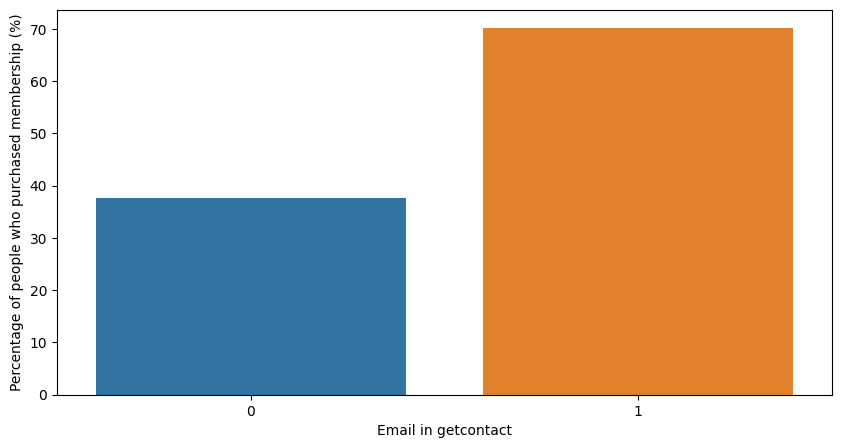

In [86]:
sns.barplot(data=plot_1, x='mail_from_dropcontact', y='my_mean').set(xlabel='Email in getcontact',
                                                                     ylabel='Percentage of people who purchased membership (%)')

plt.show()

As we can see if getcontact was able to obtain email of a person, this person is more likely to purchase membership.

## Result

1. Data was uploaded and processed.
2. Catboost model was fitted to predict result.
3. Most important features for prediction result were found.
4. An example of further data analysis was made.